In [1]:
#import Regression_variables from same directory
from regression_variable_morgan_comparison import *
from keras.optimizers import Adam

# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

2024-07-30 13:55:15.711174: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Define Neural Network Model

In [2]:
def neural_network_model(hidden1, hidden2):
    """
    Creating a neural network from two hidden layers
    using ReLU as activation function in the two hidden layers
    and a linear activation in the output layer.

    Parameters
    ----------
    hidden1 : int
        Number of neurons in first hidden layer.

    hidden2: int
        Number of neurons in second hidden layer.

    Returns
    -------
    model
        Fully connected neural network model with two hidden layers.
    """

    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="relu", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer2"))
    # Output layer
    model.add(Dense(1, activation="linear", name="layer3"))

    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

# Splits

In [3]:
compounds["Fingerprints"] = compounds["SMILES"].apply(smiles_to_fp)
x_train_rand, x_test_rand, y_train_rand, y_test_rand = random_split(compounds["Fingerprints"], compounds["f_avg_pIC50"])
x_train_strat, x_test_strat, y_train_strat, y_test_strat = strat_pIC50_split(compounds)
x_train_hi, x_test_hi, y_train_hi, y_test_hi = split_hierarchical_clusters(compounds, test_size=0.2, random_state=42)
x_train_noise, x_test_noise, y_train_noise, y_test_noise = UMAP_noise_split(compounds)
x_train_fur, x_test_fur, y_train_fur, y_test_fur = furthest_cluster_split(compounds)
# print(f"Shape of train_x: {train_x.shape}") (476,)
# print(f"Shape of test_x: {test_y.shape}") (119,)


Assign cluster ID


  0%|          | 0/595 [00:00<?, ?it/s][13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPRECATION WARNING: please use MorganGenerator
[13:55:36] DEPREC

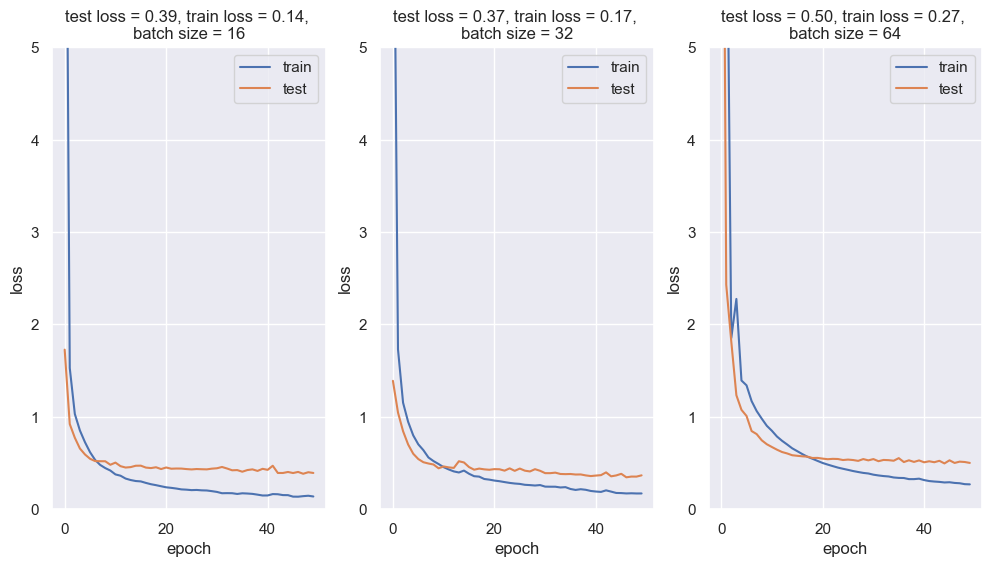

In [4]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

# Plot Random
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((x_train_rand))).astype(float), y_train_rand.values, batch_size=batch, validation_data=(np.array(list((x_test_rand))).astype(float), y_test_rand.values), verbose=0,epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 5))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, train loss = {history.history['loss'][nb_epoch-1]:.2f}, \nbatch size = {batch}"
    )
plt.show()

### Model does best with a batch size of 32

In [5]:
# Save the trained model
filepath = DATA / "best.weights.h5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model.fit(
    np.array(list((x_train_rand))).astype(float),
    y_train_rand.values,
    epochs=nb_epoch,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=0,
)

In [6]:
# Evalute the model

print(f"Evaluate the model on the test data")
scores = model.evaluate(np.array(list((x_test_rand))), y_test_rand.values, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse (same as loss): {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")
# Predict pIC50 values on x_test data

#print r2_score




Evaluate the model on the test data
 loss: 0.48
 mse (same as loss): 0.48
 mae: 0.46


In [7]:
y_pred_rand = model.predict(np.array(list((x_test_rand))))

# Print 5 first pIC50 predicted values
first_5_prediction = [print(f"{value[0]:.2f}") for value in y_pred_rand[0:5]]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4.71
5.37
4.92
6.22
4.92


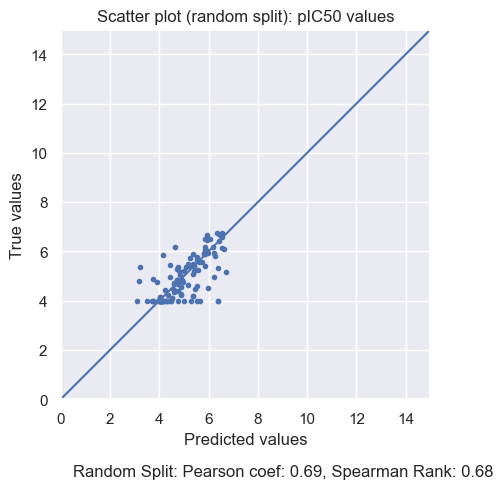

In [8]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_rand, y_test_rand, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (random split): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
pearsoncoef_rand = np.corrcoef(y_pred_rand.flatten(), y_test_rand.values.flatten())[0,1]
spearmancoef_rand = spearmanr(y_pred_rand.flatten(), y_test_rand.values.flatten()).correlation
fig.text(0.9, -0.05, f"Random Split: Pearson coef: {pearsoncoef_rand:.2f}, Spearman Rank: {spearmancoef_rand:.2f}", horizontalalignment='right', fontsize=12)
plt.show()

# Strat Split

In [9]:
print(y_train_strat)
print(y_test_strat)

43     4.427046
453    4.002177
376    5.263954
91     4.013475
452    4.059631
         ...   
562    6.365817
495    5.749483
394    4.002177
201    4.002177
145    4.002177
Name: f_avg_pIC50, Length: 476, dtype: float64
507    6.655152
464    5.896846
26     5.561432
533    4.002177
31     4.831952
         ...   
36     4.916740
29     5.361479
251    5.144261
535    4.002177
349    4.697309
Name: f_avg_pIC50, Length: 119, dtype: float64


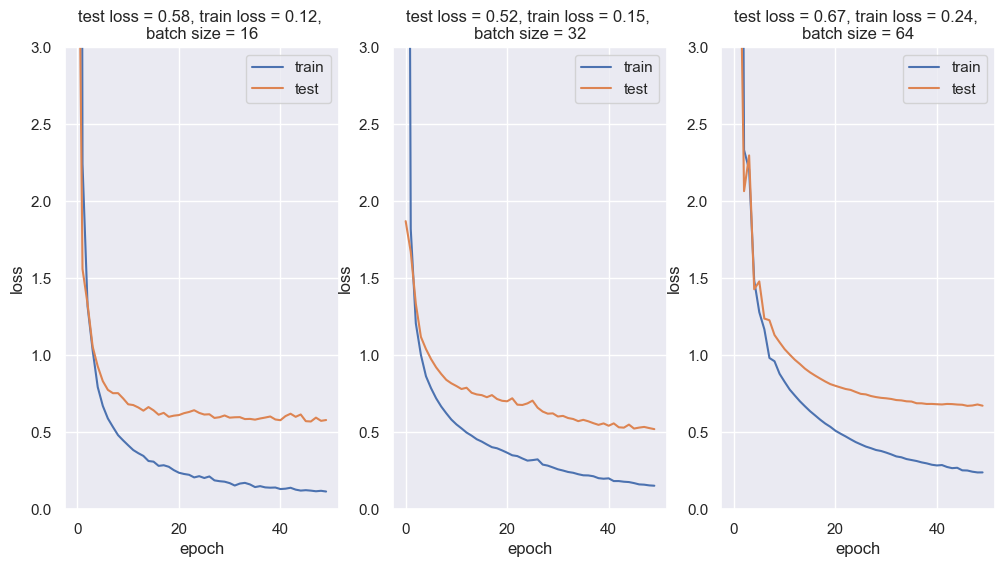

In [10]:
# Neural network parameters
#number of training samples used in one forward/backward pass
batch_sizes = [16, 32, 64]
# epoch is one complete pass through the entire training dataset.
#higher epoch can improve model performance but may lead to overfitting
nb_epoch = 50
#number of neurons in the first and secondb hidden layer 
layer1_size = 64
layer2_size = 32

# Plot test loss scores
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model_strat = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history_strat = model_strat.fit(
        np.array(list((x_train_strat))).astype(float),
        y_train_strat.values,
        batch_size=batch,
        validation_data=(np.array(list((x_test_strat))).astype(float), y_test_strat.values),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history_strat.history["loss"], label="train")
    plt.plot(history_strat.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 3))
    plt.title(
        f"test loss = {history_strat.history['val_loss'][nb_epoch-1]:.2f}, train loss = {history_strat.history['loss'][nb_epoch-1]:.2f}, \nbatch size = {batch}"
    )
plt.show()

### Test and train loss seem to be lowest with batch size of 16

In [11]:
# Save the trained model
filepath = DATA / "best.strat.weights.h5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model_strat.fit(
    np.array(list((x_train_strat))).astype(float),
    y_train_strat.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

# Evalute the model
print(f"Evaluate the ANN model on the test data: Stratified Split (pIC50 values)")
scores_strat = model_strat.evaluate(np.array(list((x_test_strat))), y_test_strat.values, verbose=0)
print(f" loss: {scores_strat[0]:.2f}")
print(f" mse (same as loss): {scores_strat[1]:.2f}")
print(f" mae: {scores_strat[2]:.2f}")

Evaluate the ANN model on the test data: Stratified Split (pIC50 values)
 loss: 0.56
 mse (same as loss): 0.56
 mae: 0.51


In [12]:
# Predict pIC50 values on x_test data
y_pred_strat = model_strat.predict(np.array(list((x_test_strat))))

# Print 5 first pIC50 predicted values
first_5_prediction_strat = [print(f"{value[0]:.2f}") for value in y_pred_strat[0:5]]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6.81
4.85
5.34
3.96
5.08


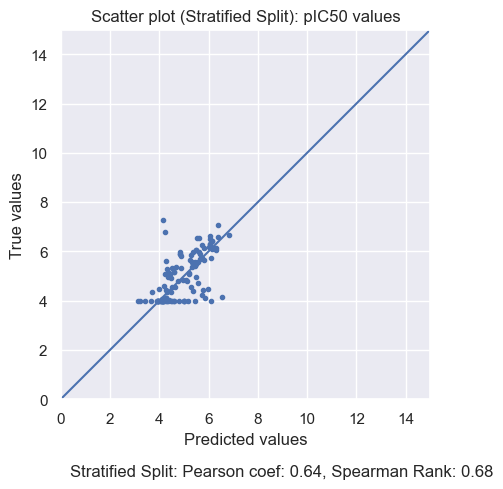

In [13]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_strat, y_test_strat, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (Stratified Split): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
pearsoncoef_strat = np.corrcoef(y_pred_strat.flatten(), y_test_strat.values.flatten())[0,1]
spearmancoef_strat = spearmanr(y_pred_strat.flatten(), y_test_strat.values.flatten()).correlation
fig.text(0.9, -0.05, f"Stratified Split: Pearson coef: {pearsoncoef_strat:.2f}, Spearman Rank: {spearmancoef_strat:.2f}", horizontalalignment='right', fontsize=12)
plt.show()

# Hierarchical Clustering Split

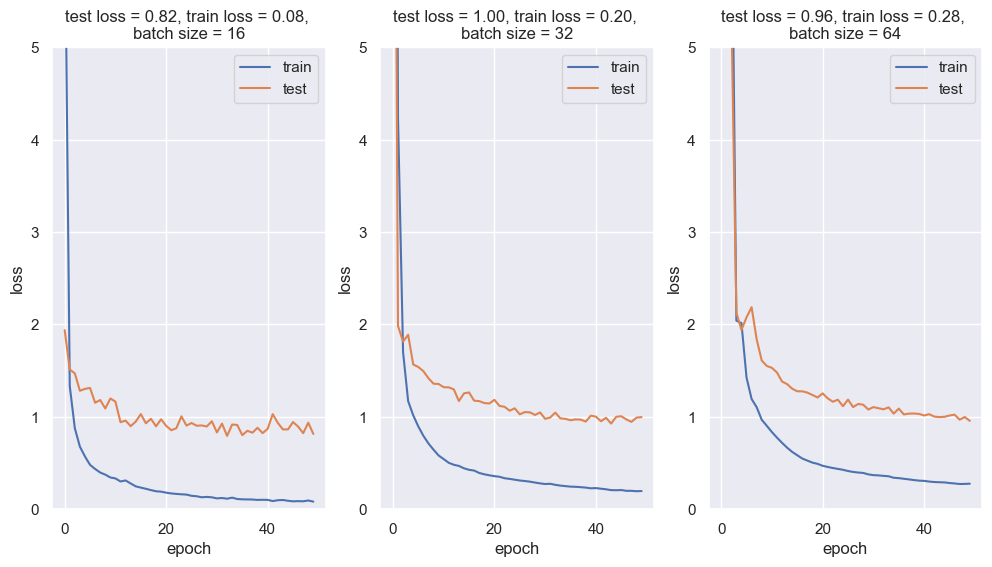

In [14]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

# Plot Random
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model_hi = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history_hi = model_hi.fit(
        np.array(list((x_train_hi))).astype(float), y_train_hi.values, batch_size=batch, validation_data=(np.array(list((x_test_hi))).astype(float), y_test_hi.values), verbose=0,epochs=nb_epoch,
    )
    plt.plot(history_hi.history["loss"], label="train")
    plt.plot(history_hi.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 5))
    plt.title(
        f"test loss = {history_hi.history['val_loss'][nb_epoch-1]:.2f}, train loss = {history_hi.history['loss'][nb_epoch-1]:.2f}, \nbatch size = {batch}"
    )
plt.show()

In [15]:
# Save the trained model
filepath = DATA / "best.hierarc.weights.h5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model_hi.fit(
    np.array(list((x_train_hi))).astype(float),
    y_train_hi.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

# Evalute the model
print(f"Evaluate the ANN model on the test data: Hierarchical Cluster Split")
scores_hi = model_hi.evaluate(np.array(list((x_test_hi))), y_test_hi.values, verbose=0)
print(f" loss: {scores_hi[0]:.2f}")
print(f" mse (same as loss): {scores_hi[1]:.2f}")
print(f" mae: {scores_hi[2]:.2f}")

Evaluate the ANN model on the test data: Hierarchical Cluster Split
 loss: 1.03
 mse (same as loss): 1.03
 mae: 0.78


In [16]:
# Predict pIC50 values on x_test data
y_pred_hi = model_hi.predict(np.array(list((x_test_hi))))

# Print 5 first pIC50 predicted values
first_5_prediction_hi = [print(f"{value[0]:.2f}") for value in y_pred_hi[0:5]]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x1687bb560> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5.04
5.70
5.57
5.79
5.34


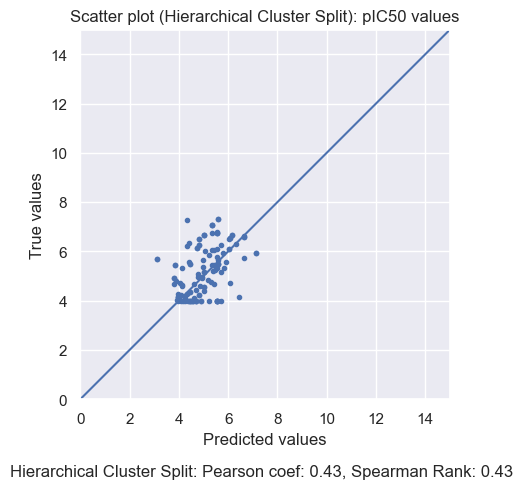

In [17]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_hi, y_test_hi, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (Hierarchical Cluster Split): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
pearsoncoef_hi = np.corrcoef(y_pred_hi.flatten(), y_test_hi.values.flatten())[0,1]
spearmancoef_hi = spearmanr(y_pred_hi.flatten(), y_test_hi.values.flatten()).correlation
fig.text(0.9, -0.05, f"Hierarchical Cluster Split: Pearson coef: {pearsoncoef_hi:.2f}, Spearman Rank: {spearmancoef_hi:.2f}", horizontalalignment='right', fontsize=12)
plt.show()

# UMAP Furthest Cluster Split

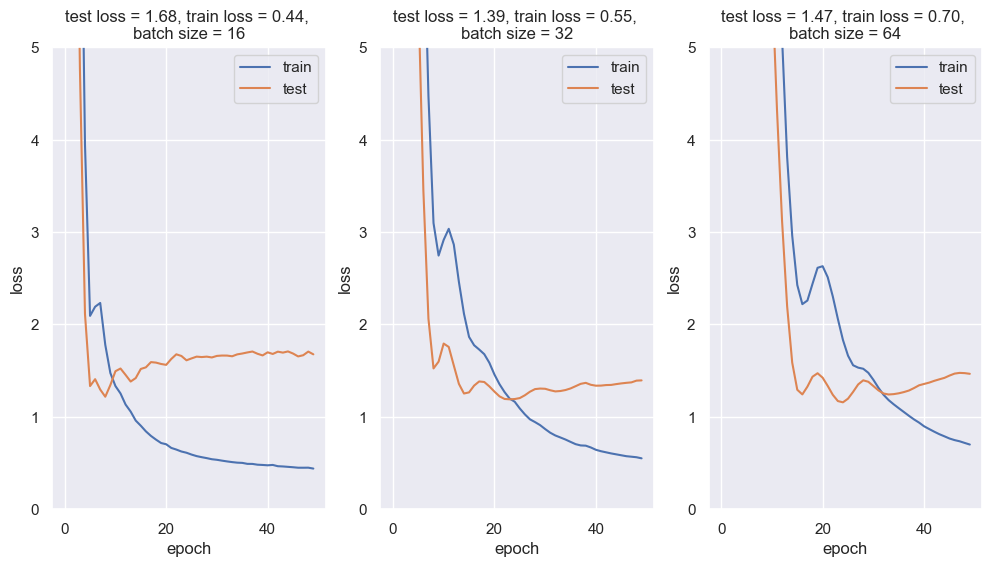

In [18]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

# Plot Random
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model_fur = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history_fur = model_fur.fit(
        np.array(list((x_train_fur))).astype(float), y_train_fur.values, batch_size=batch, validation_data=(np.array(list((x_test_fur))).astype(float), y_test_fur.values), verbose=0,epochs=nb_epoch,
    )
    plt.plot(history_fur.history["loss"], label="train")
    plt.plot(history_fur.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 5))
    plt.title(
        f"test loss = {history_fur.history['val_loss'][nb_epoch-1]:.2f}, train loss = {history_fur.history['loss'][nb_epoch-1]:.2f}, \nbatch size = {batch}"
    )
plt.show()

### In the three plots above we observe the test reach a lowest point and then increase. This is indicative of overfitting and we must do something about this. 

In [19]:
# Save the trained model
filepath = DATA / "best.fur.weights.h5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model_fur.fit(
    np.array(list((x_train_fur))).astype(float),
    y_train_fur.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

# Evalute the model
print(f"Evaluate the ANN model on the test data: UMAP Furthest Cluster Split")
scores_fur = model_fur.evaluate(np.array(list((x_test_fur))), y_test_fur.values, verbose=0)
print(f" loss: {scores_fur[0]:.2f}")
print(f" mse (same as loss): {scores_fur[1]:.2f}")
print(f" mae: {scores_fur[2]:.2f}")

Evaluate the ANN model on the test data: UMAP Furthest Cluster Split
 loss: 1.61
 mse (same as loss): 1.61
 mae: 0.98


In [20]:
# Predict pIC50 values on x_test data
y_pred_fur = model_fur.predict(np.array(list((x_test_fur))))

# Print 5 first pIC50 predicted values
first_5_prediction_fur = [print(f"{value[0]:.2f}") for value in y_pred_fur[0:5]]

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4.76
4.70
4.03
5.00
3.92


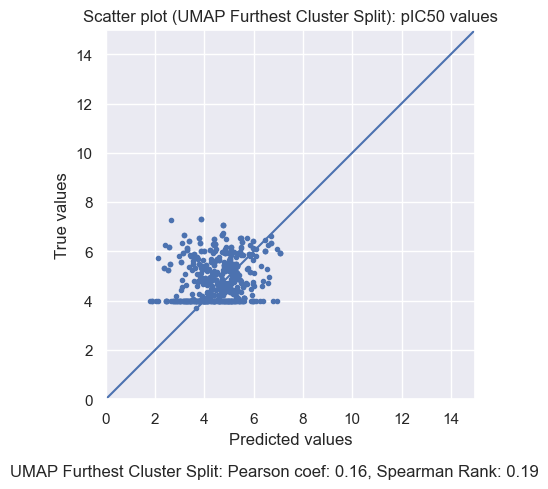

In [21]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_fur, y_test_fur, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (UMAP Furthest Cluster Split): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
pearsoncoef_fur = np.corrcoef(y_pred_fur.flatten(), y_test_fur.values.flatten())[0,1]
spearmancoef_fur = spearmanr(y_pred_fur.flatten(), y_test_fur.values.flatten()).correlation
fig.text(0.9, -0.05, f"UMAP Furthest Cluster Split: Pearson coef: {pearsoncoef_fur:.2f}, Spearman Rank: {spearmancoef_fur:.2f}", horizontalalignment='right', fontsize=12)
plt.show()

# UMAP Noise Split


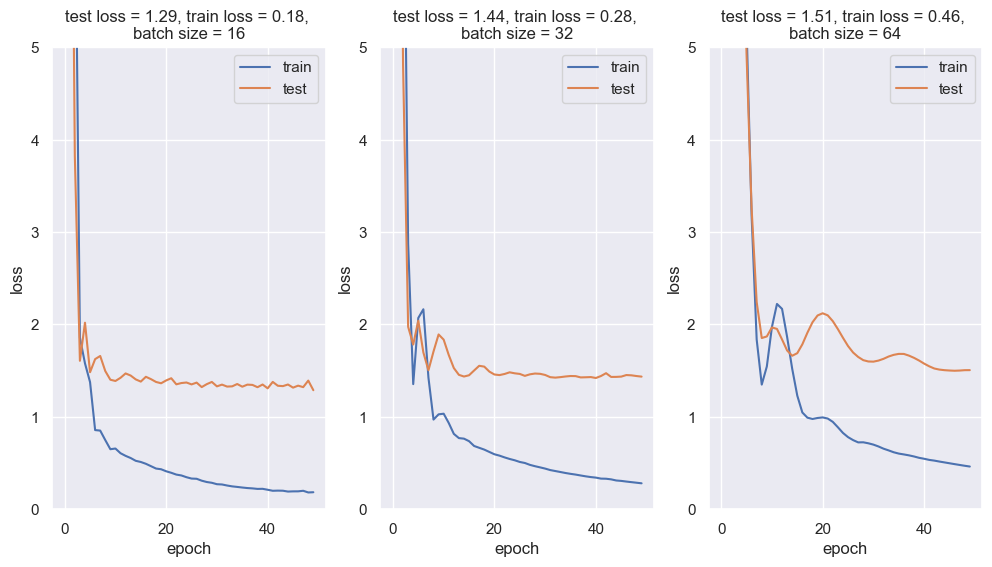

In [22]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

# Plot Random
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model_noise = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history_noise = model_noise.fit(
        np.array(list((x_train_noise))).astype(float), y_train_noise.values, batch_size=batch, validation_data=(np.array(list((x_test_noise))).astype(float), y_test_noise.values), verbose=0,epochs=nb_epoch,
    )
    plt.plot(history_noise.history["loss"], label="train")
    plt.plot(history_noise.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 5))
    plt.title(
        f"test loss = {history_noise.history['val_loss'][nb_epoch-1]:.2f}, train loss = {history_noise.history['loss'][nb_epoch-1]:.2f}, \nbatch size = {batch}"
    )
plt.show()

In [23]:
# Save the trained model
filepath = DATA / "best.noise.weights.h5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model_noise.fit(
    np.array(list((x_train_noise))).astype(float),
    y_train_noise.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

# Evalute the model
print(f"Evaluate the ANN model on the test data: UMAP Noise Split")
scores_noise = model_noise.evaluate(np.array(list((x_test_noise))), y_test_noise.values, verbose=0)
print(f" loss: {scores_noise[0]:.2f}")
print(f" mse (same as loss): {scores_noise[1]:.2f}")
print(f" mae: {scores_noise[2]:.2f}")

Evaluate the ANN model on the test data: UMAP Noise Split
 loss: 1.26
 mse (same as loss): 1.26
 mae: 0.92


In [24]:
# Predict pIC50 values on x_test data
y_pred_noise = model_noise.predict(np.array(list((x_test_noise))))

# Print 5 first pIC50 predicted values
first_5_prediction_noise = [print(f"{value[0]:.2f}") for value in y_pred_noise[0:5]]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4.03
4.04
3.54
3.46
2.81


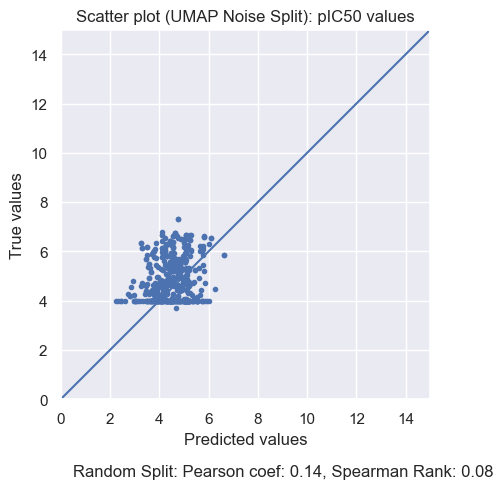

In [25]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_noise, y_test_noise, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (UMAP Noise Split): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
pearsoncoef_noise = np.corrcoef(y_pred_noise.flatten(), y_test_noise.values.flatten())[0,1]
spearmancoef_noise = spearmanr(y_pred_noise.flatten(), y_test_noise.values.flatten()).correlation
fig.text(0.9, -0.05, f"Random Split: Pearson coef: {pearsoncoef_noise:.2f}, Spearman Rank: {spearmancoef_noise:.2f}", horizontalalignment='right', fontsize=12)
plt.show()

In [26]:
# Plot a table of the 5 different splits and their respective Pearson and Spearman Rank correlation coefficients, test loss, train loss and mean absolute error
#get train loss variable from optimised random split
train_loss_rand = history.history["loss"][nb_epoch-1]

split_scores_initial = {
    "Split": ["Random", "Stratified pIC50", "Hierarchical Clustering", "UMAP Furthest Cluster", "UMAP Noise"],
    "Pearson Coef": [pearsoncoef_rand, pearsoncoef_strat, pearsoncoef_hi, pearsoncoef_fur, pearsoncoef_noise],
    "Spearman Rank": [spearmancoef_rand, spearmancoef_strat, spearmancoef_hi, spearmancoef_fur, spearmancoef_noise],
    "Test Loss": [scores[0], scores_strat[0], scores_hi[0], scores_fur[0], scores_noise[0]],
    "Train Loss": [history.history["loss"][nb_epoch-1],  history_strat.history["loss"][nb_epoch-1], history_hi.history["loss"][nb_epoch-1], history_fur.history["loss"][nb_epoch-1], history_noise.history["loss"][nb_epoch-1]],
    "Mean Absolute Error": [scores[2], scores_strat[2], scores_hi[2], scores_fur[2], scores_noise[2]],
}
split_scores_initial_df = pd.DataFrame(split_scores_initial)
split_scores_initial_df.set_index("Split", inplace=True)
#save df to csv in data file
split_scores_initial_df.to_csv(DATA / "split_scores_initial.csv")

print(split_scores_initial_df)


                         Pearson Coef  Spearman Rank  Test Loss  Train Loss  \
Split                                                                         
Random                       0.686903       0.681308   0.476663    0.269503   
Stratified pIC50             0.640876       0.679336   0.563536    0.239287   
Hierarchical Clustering      0.431932       0.432825   1.025030    0.276819   
UMAP Furthest Cluster        0.164013       0.185810   1.612518    0.700292   
UMAP Noise                   0.138459       0.081304   1.262254    0.462316   

                         Mean Absolute Error  
Split                                         
Random                              0.455111  
Stratified pIC50                    0.510560  
Hierarchical Clustering             0.776173  
UMAP Furthest Cluster               0.978552  
UMAP Noise                          0.919235  


# Optuna 

In [27]:
# # params in ANN: batch size, number of epochs, number of neurons in the first and second hidden layer
# def objective(trial, X_train, y_train, X_test, y_test):
#     nb_epochs = trial.suggest_int('nb_epochs', 10, 100)
#     batch_size = trial.suggest_int("batch_size", 4, 32)
#     layer1_size = trial.suggest_int("layer1_size", 16, 128)
#     layer2_size = trial.suggest_int("layer2_size", 16, 128)

#     model = neural_network_model(layer1_size, layer2_size)

#     # Fit the model
#     model.fit(X_train, y_train, epochs=nb_epochs, verbose=0)

#     # Evaluate the model
#     score = model.evaluate(X_test, y_test, verbose=0)
#     return score


def objective(trial, x_train, y_train, x_test, y_test):
    try:
        nb_epochs = trial.suggest_int('epochs', 30, 100)
        batch_size = trial.suggest_int('batch_size', 16, 64)
        layer1_size = trial.suggest_int('units_layer1', 16, 128)
        layer2_size = trial.suggest_int('units_layer2', 16, 128)
        # Define the model
        model = Sequential()
        model.add(Dense(units=layer1_size, activation='relu', input_shape=(x_train.shape[1],)))
        model.add(Dense(units=layer2_size, activation='relu'))
        model.add(Dense(1, activation='linear'))
        
        # Compile the model
        model.compile(optimizer=Adam(), loss='mean_squared_error')
        
        # Fit the model
        model.fit(x_train, 
                  y_train, 
                  epochs= nb_epochs, 
                  batch_size=batch_size, 
                  verbose=0)
        
        # Evaluate the model
        score = model.evaluate(x_test, y_test, verbose=0)
        
        return score
    except Exception as e:
        print(f"An error occurred: {e}")
        raise

In [28]:
study_rand_ANN = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))
# study_strat_ANN = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))
# study_hi_ANN = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))
# study_noise_ANN = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))
# study_fur_ANN = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=SEED))

[I 2024-07-30 13:57:57,390] A new study created in memory with name: no-name-6a02e5a0-be40-425c-b9f1-209b4450acd1


In [29]:
#add trials using study.optimize
# Ensure x_train_rand is a NumPy array of floats
study_rand_ANN.optimize(lambda trial: objective(trial, np.array(list((x_train_rand))).astype(float), y_train_rand, np.array(list((x_test_rand))).astype(float), y_test_rand), n_trials=400, show_progress_bar=True)

  0%|          | 0/400 [00:00<?, ?it/s]

[I 2024-07-30 13:58:01,418] Trial 0 finished with value: 0.46111175417900085 and parameters: {'epochs': 56, 'batch_size': 62, 'units_layer1': 98, 'units_layer2': 83}. Best is trial 0 with value: 0.46111175417900085.
[I 2024-07-30 13:58:05,730] Trial 1 finished with value: 0.4801611304283142 and parameters: {'epochs': 41, 'batch_size': 23, 'units_layer1': 22, 'units_layer2': 113}. Best is trial 1 with value: 0.4801611304283142.
[I 2024-07-30 13:58:11,465] Trial 2 finished with value: 0.45654532313346863 and parameters: {'epochs': 72, 'batch_size': 50, 'units_layer1': 18, 'units_layer2': 125}. Best is trial 1 with value: 0.4801611304283142.
[I 2024-07-30 13:58:18,372] Trial 3 finished with value: 0.47818723320961 and parameters: {'epochs': 89, 'batch_size': 26, 'units_layer1': 36, 'units_layer2': 36}. Best is trial 1 with value: 0.4801611304283142.
[I 2024-07-30 13:58:22,396] Trial 4 finished with value: 0.47768861055374146 and parameters: {'epochs': 51, 'batch_size': 41, 'units_layer1':

In [30]:
best_params_rand_ANN = study_rand_ANN.best_params
print(best_params_rand_ANN)

{'epochs': 50, 'batch_size': 44, 'units_layer1': 19, 'units_layer2': 20}


In [31]:
best_units_rand_ANN = best_params_rand_ANN["units_layer1"]
best_units_layer2_rand_ANN = best_params_rand_ANN["units_layer2"]
best_epochs_rand_ANN = best_params_rand_ANN["epochs"]
best_batch_size_rand_ANN = best_params_rand_ANN["batch_size"]

In [32]:
ANN_rand_best = neural_network_model(best_units_rand_ANN, best_units_layer2_rand_ANN)
history_rand_best = ANN_rand_best.fit(
    np.array(list((x_train_rand))).astype(float),
    y_train_rand,
    epochs=best_epochs_rand_ANN,
    batch_size=best_batch_size_rand_ANN,
    verbose=0
)
y_pred_ANN_rand_best = ANN_rand_best.predict(np.array(list((x_test_rand))))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


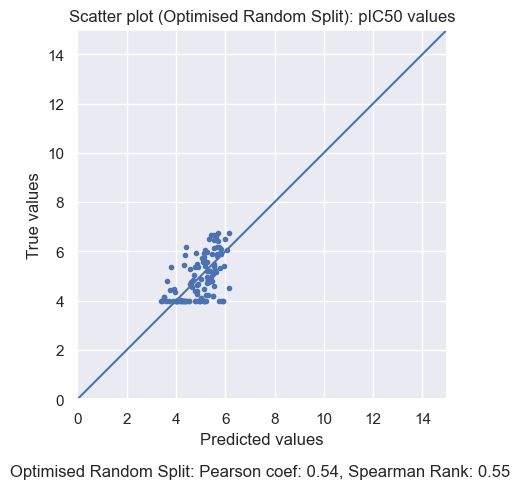

In [33]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred_ANN_rand_best, y_test_rand, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot (Optimised Random Split): pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
pearsoncoef_ANN_rand_best = np.corrcoef(y_pred_ANN_rand_best.flatten(), y_test_rand.values.flatten())[0,1]
spearmancoef_ANN_rand_best = spearmanr(y_pred_ANN_rand_best.flatten(), y_test_rand.values.flatten()).correlation
fig.text(0.9, -0.05, f"Optimised Random Split: Pearson coef: {pearsoncoef_ANN_rand_best:.2f}, Spearman Rank: {spearmancoef_ANN_rand_best:.2f}", horizontalalignment='right', fontsize=12)
plt.show()

In [34]:
mae_ANN_rand_best = mean_absolute_error(y_test_rand, y_pred_ANN_rand_best)
mse_ANN_rand_best = mean_squared_error(y_test_rand, y_pred_ANN_rand_best)
train_loss_ANN_rand_best = history_rand_best.history["loss"][best_epochs_rand_ANN-1]

split_scores_best = {
    "Split": ["Random", "Optimised Random", "Stratified pIC50", "Hierarchical Clustering", "UMAP Furthest Cluster", "UMAP Noise"],
    "Pearson Coef": [pearsoncoef_rand, pearsoncoef_ANN_rand_best, pearsoncoef_strat, pearsoncoef_hi, pearsoncoef_fur, pearsoncoef_noise],
    "Spearman Rank": [spearmancoef_rand, spearmancoef_ANN_rand_best, spearmancoef_strat, spearmancoef_hi, spearmancoef_fur, spearmancoef_noise],
    "Test Loss": [scores[0],  mse_ANN_rand_best, scores_strat[0], scores_hi[0], scores_fur[0], scores_noise[0]],
    "Train Loss": [history.history["loss"][nb_epoch-1], train_loss_ANN_rand_best, history_strat.history["loss"][nb_epoch-1], history_hi.history["loss"][nb_epoch-1], history_fur.history["loss"][nb_epoch-1], history_noise.history["loss"][nb_epoch-1]],
    "Mean Absolute Error": [scores[2], mae_ANN_rand_best, scores_strat[2], scores_hi[2], scores_fur[2], scores_noise[2]],
}
split_scores_best_df = pd.DataFrame(split_scores_best)
split_scores_best_df.set_index("Split", inplace=True)
#save df to csv in data file
split_scores_best_df.to_csv(DATA / "split_scores_best.csv")

print(split_scores_best_df)


                         Pearson Coef  Spearman Rank  Test Loss  Train Loss  \
Split                                                                         
Random                       0.686903       0.681308   0.476663    0.269503   
Optimised Random             0.536290       0.545661   0.576734    0.445455   
Stratified pIC50             0.640876       0.679336   0.563536    0.239287   
Hierarchical Clustering      0.431932       0.432825   1.025030    0.276819   
UMAP Furthest Cluster        0.164013       0.185810   1.612518    0.700292   
UMAP Noise                   0.138459       0.081304   1.262254    0.462316   

                         Mean Absolute Error  
Split                                         
Random                              0.455111  
Optimised Random                    0.605469  
Stratified pIC50                    0.510560  
Hierarchical Clustering             0.776173  
UMAP Furthest Cluster               0.978552  
UMAP Noise                          0.